In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time
import random
from tqdm import tqdm
import cv2
import warnings

warnings.filterwarnings('ignore')

In [3]:
DATA_DIR = '../processedDatasets/data_balanced/'
MODEL_SAVE_DIR = '../models/'
REPORTS_DIR = '../reports/figures/'
MODEL_WEIGHTS_FILENAME = 'resnet50_alzheimer_v2_gradcam_friendly.weights.h5'
MODEL_WEIGHTS_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_WEIGHTS_FILENAME)

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 50

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'val'),
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15353 files belonging to 4 classes.


I0000 00:00:1754978350.586180   47934 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21169 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 2323 files belonging to 4 classes.
Found 2324 files belonging to 4 classes.


In [5]:
def build_gradcam_friendly_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    preprocessed_input = tf.keras.applications.resnet50.preprocess_input(inputs)
    
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=preprocessed_input)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', name='dense_hidden')(x)
    outputs = Dense(NUM_CLASSES, activation='softmax', name='dense_output')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_gradcam_friendly_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50


I0000 00:00:1754978384.940861   48135 service.cc:152] XLA service 0x7cc930012bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754978384.940892   48135 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1754978386.421741   48135 cuda_dnn.cc:529] Loaded cuDNN version 90501


  5/480 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.2865 - loss: 2.9166

I0000 00:00:1754978390.411871   48135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


480/480 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.6789 - loss: 0.7648 - val_accuracy: 0.6375 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7438 - loss: 0.5868 - val_accuracy: 0.7344 - val_loss: 0.6704 - learning_rate: 0.0010
Epoch 3/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7769 - loss: 0.5285 - val_accuracy: 0.7645 - val_loss: 0.6086 - learning_rate: 0.0010
Epoch 4/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7928 - loss: 0.4875 - val_accuracy: 0.7835 - val_loss: 0.5634 - learning_rate: 0.0010
Epoch 5/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8149 - loss: 0.4415 - val_accuracy: 0.8033 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 6/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8273 - loss: 0.4122 - val_accuracy: 0.8209 - val_loss: 0.4731 - learning_rate: 0.0010
Epoch 7/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8406 - loss: 0.3857

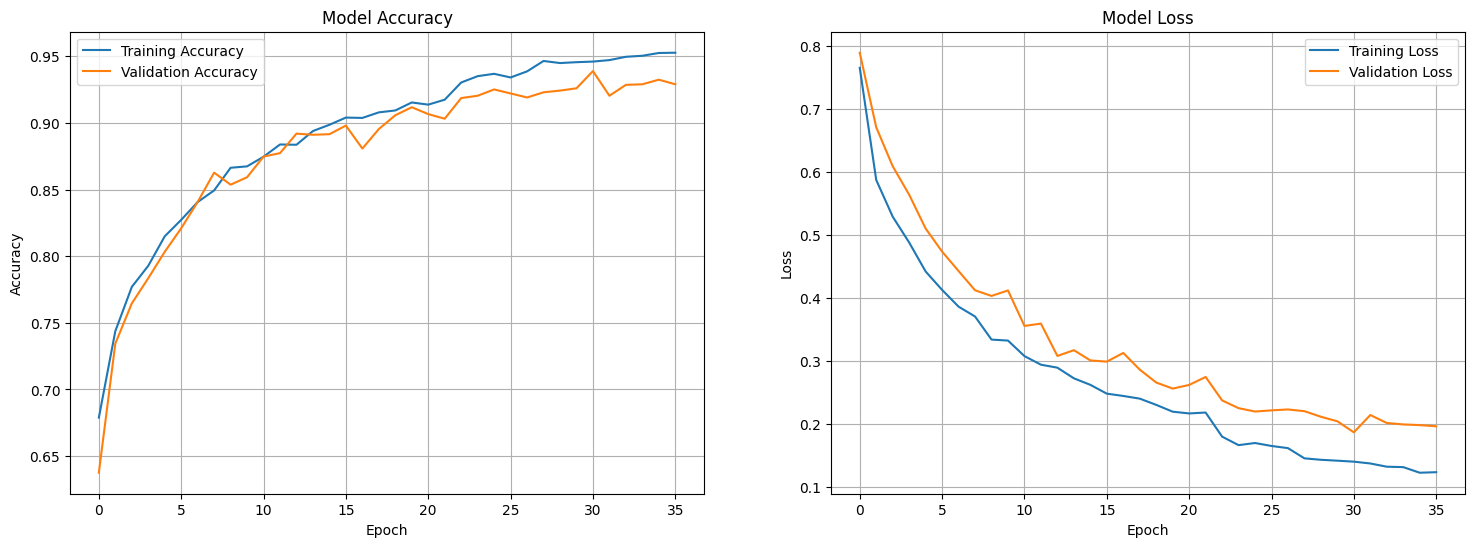

In [6]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
checkpoint_cb = ModelCheckpoint(filepath=MODEL_WEIGHTS_SAVE_PATH, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy'); ax1.legend(); ax1.grid(True)
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss'); ax2.legend(); ax2.grid(True)
plt.savefig(os.path.join(REPORTS_DIR, 'training_history_v2.png'))
plt.show()

In [7]:
model.load_weights(MODEL_WEIGHTS_SAVE_PATH)
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9376 - loss: 0.1854

Test Loss: 0.1854
Test Accuracy: 93.76%


✨ Bắt đầu đánh giá độ trung thực Grad-CAM++ trên 8 ảnh ngẫu nhiên...
---
Ảnh #15 - Nhãn thực tế: Mild_Dementia
  - Ban đầu: Dự đoán 'Mild_Dementia' với độ tự tin 98.43%
  - Sau khi xóa vùng quan trọng: Dự đoán 'Non_Dementia' với độ tự tin 98.84%
  => Độ tự tin giảm: -0.40%
---


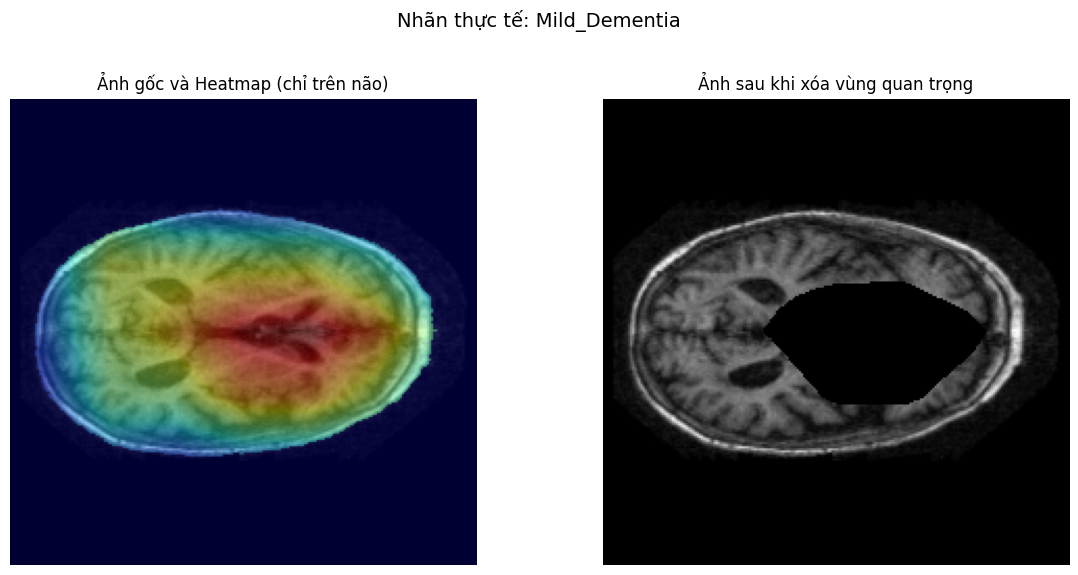

Ảnh #28 - Nhãn thực tế: Mild_Dementia
  - Ban đầu: Dự đoán 'Mild_Dementia' với độ tự tin 97.24%
  - Sau khi xóa vùng quan trọng: Dự đoán 'Non_Dementia' với độ tự tin 93.79%
  => Độ tự tin giảm: 3.45%
---


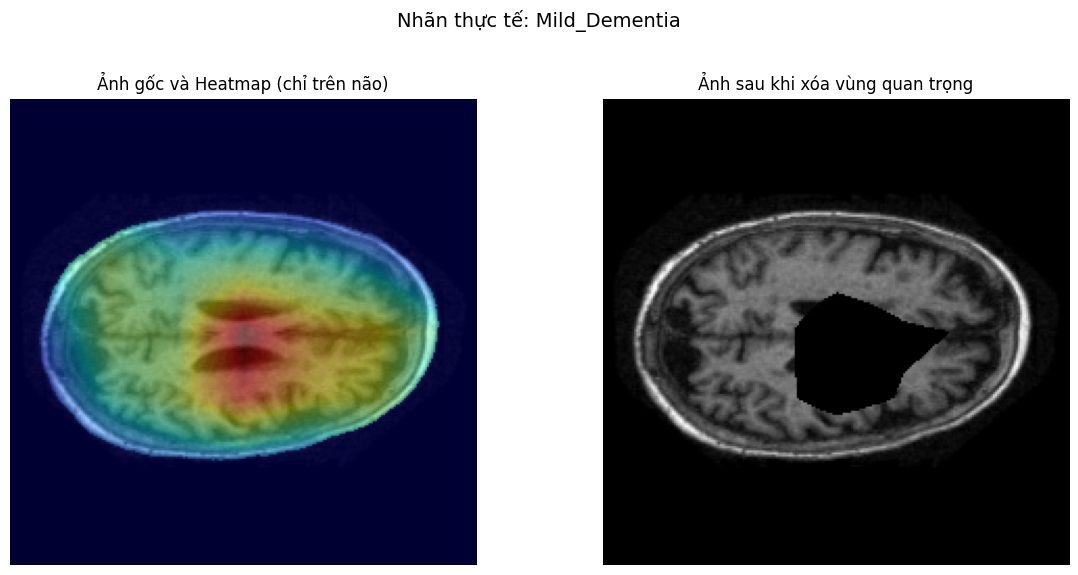

Ảnh #22 - Nhãn thực tế: Mild_Dementia
  - Ban đầu: Dự đoán 'Mild_Dementia' với độ tự tin 95.80%
  - Sau khi xóa vùng quan trọng: Dự đoán 'Very_mild_Dementia' với độ tự tin 51.42%
  => Độ tự tin giảm: 44.37%
---


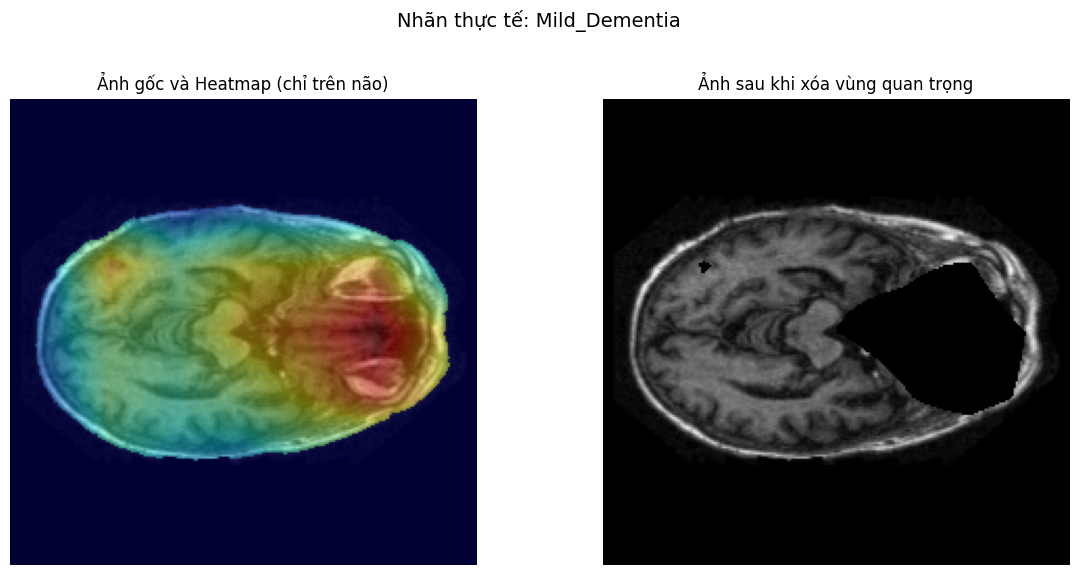

Ảnh #11 - Nhãn thực tế: Mild_Dementia
  - Ban đầu: Dự đoán 'Mild_Dementia' với độ tự tin 89.83%
  - Sau khi xóa vùng quan trọng: Dự đoán 'Very_mild_Dementia' với độ tự tin 50.39%
  => Độ tự tin giảm: 39.44%
---


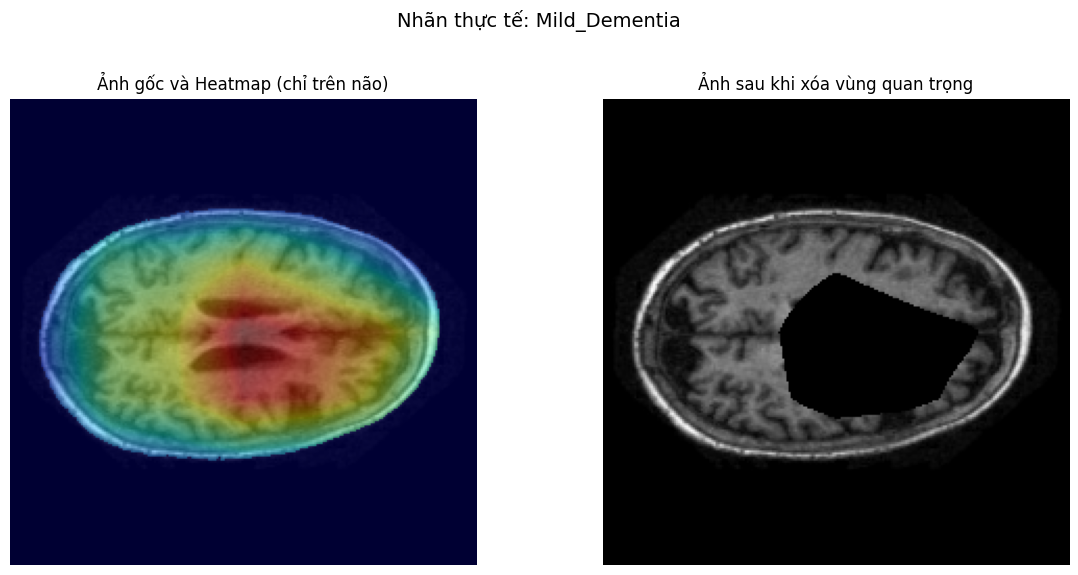

Ảnh #29 - Nhãn thực tế: Mild_Dementia
  - Ban đầu: Dự đoán 'Mild_Dementia' với độ tự tin 100.00%
  - Sau khi xóa vùng quan trọng: Dự đoán 'Mild_Dementia' với độ tự tin 68.33%
  => Độ tự tin giảm: 31.67%
---


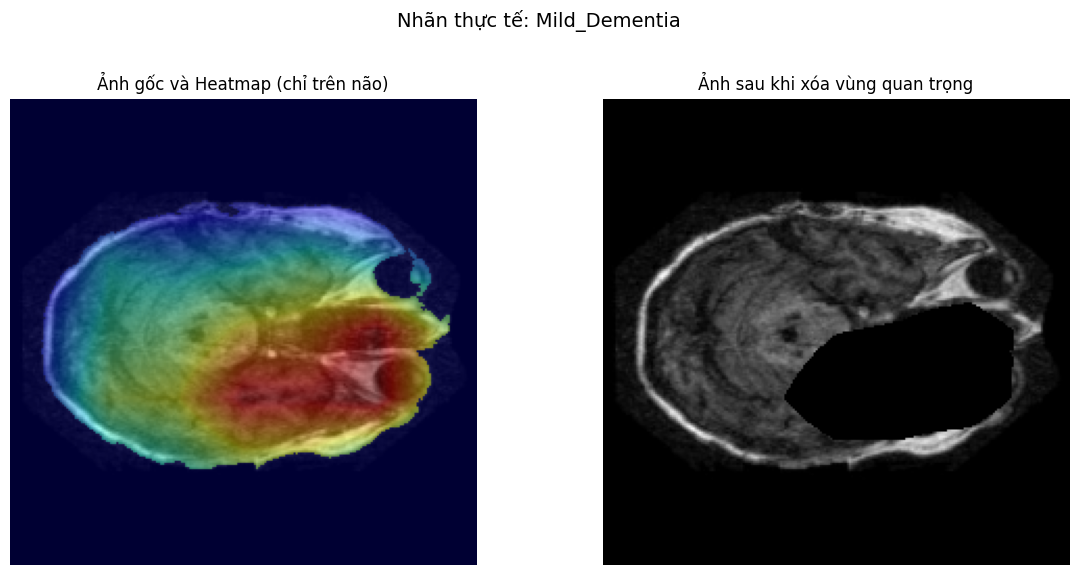

Ảnh #24 - Nhãn thực tế: Mild_Dementia
  - Ban đầu: Dự đoán 'Mild_Dementia' với độ tự tin 58.21%
  - Sau khi xóa vùng quan trọng: Dự đoán 'Non_Dementia' với độ tự tin 87.13%
  => Độ tự tin giảm: -28.92%
---


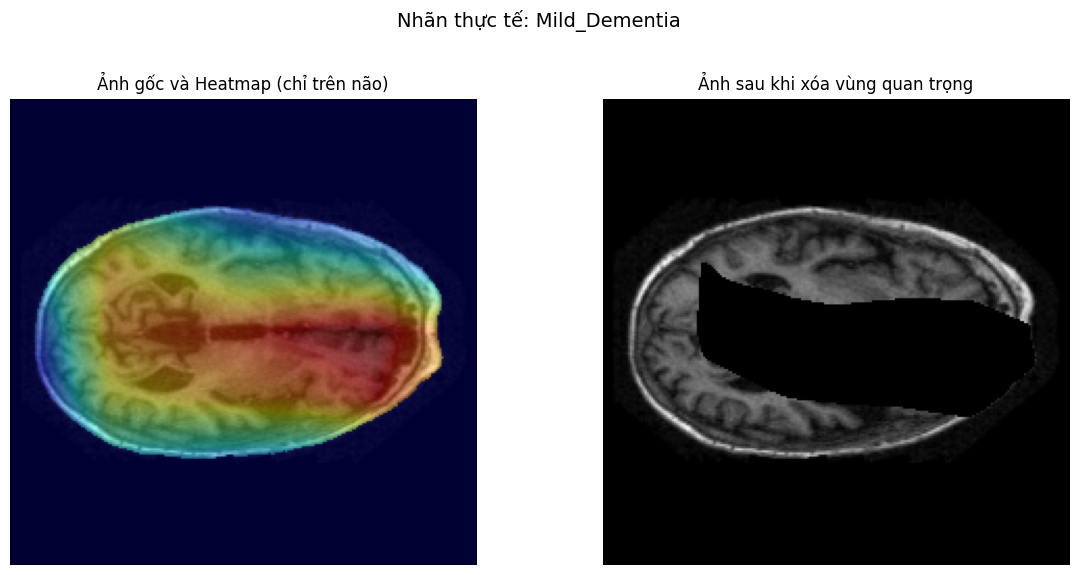

Ảnh #18 - Nhãn thực tế: Mild_Dementia
  - Ban đầu: Dự đoán 'Mild_Dementia' với độ tự tin 96.73%
  - Sau khi xóa vùng quan trọng: Dự đoán 'Very_mild_Dementia' với độ tự tin 67.11%
  => Độ tự tin giảm: 29.62%
---


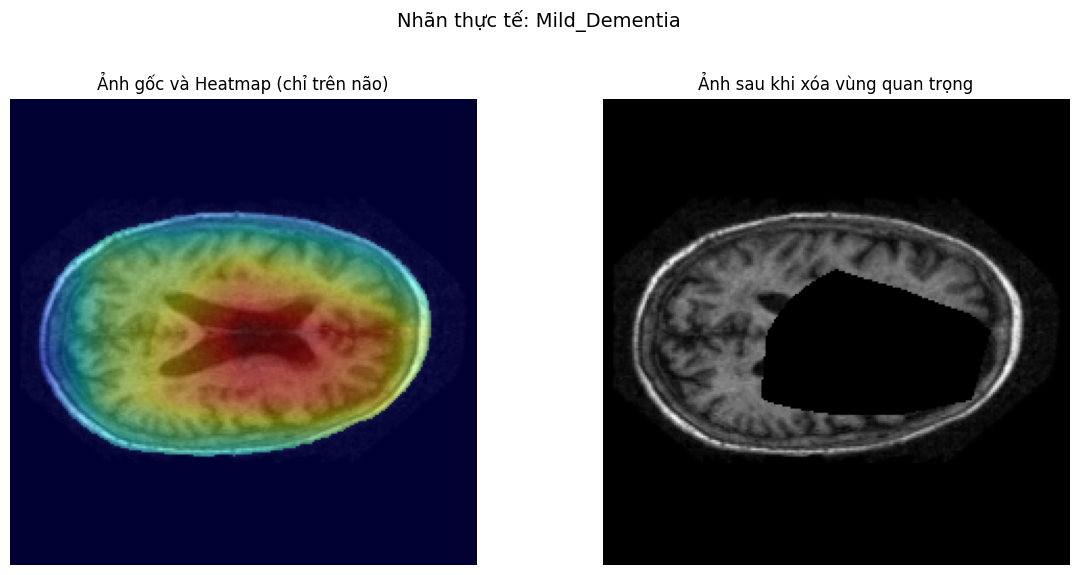

Ảnh #17 - Nhãn thực tế: Mild_Dementia
  - Ban đầu: Dự đoán 'Mild_Dementia' với độ tự tin 99.23%
  - Sau khi xóa vùng quan trọng: Dự đoán 'Non_Dementia' với độ tự tin 73.17%
  => Độ tự tin giảm: 26.06%
---


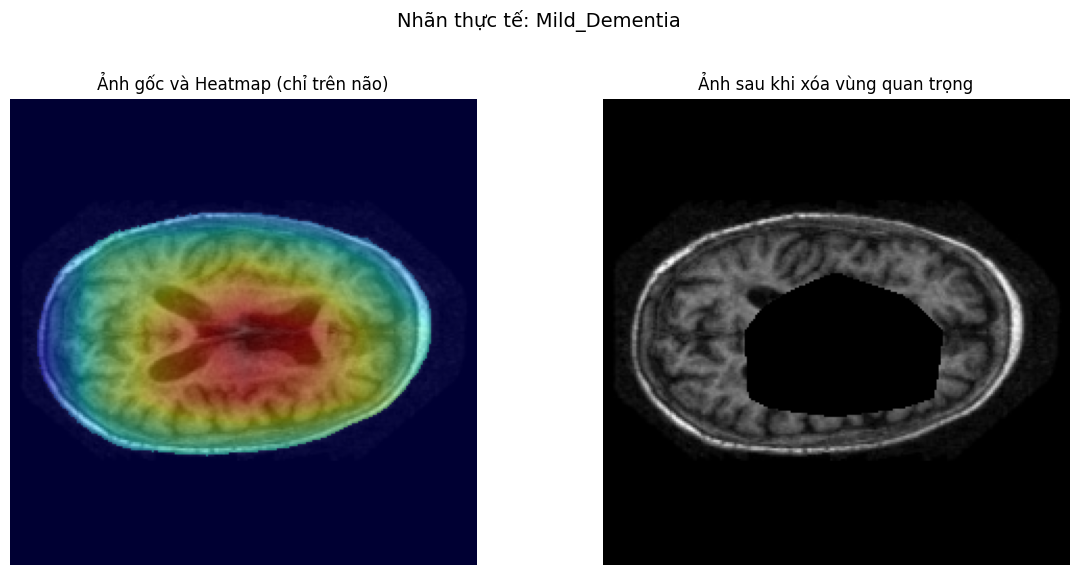


✅ Đã hoàn tất quá trình đánh giá.


In [11]:
# Tải lại trọng số để chắc chắn
model.load_weights(MODEL_WEIGHTS_SAVE_PATH)

# Lấy một batch từ tập test, đảm bảo có ít nhất 8 ảnh
for image_batch, label_batch in test_ds.take(1):
    if image_batch.shape[0] >= 8:
        break

num_images_to_evaluate = 8
random_indices = random.sample(range(image_batch.shape[0]), num_images_to_evaluate)

print(f"✨ Bắt đầu đánh giá độ trung thực Grad-CAM++ trên {num_images_to_evaluate} ảnh ngẫu nhiên...")
print("---")

# Ngưỡng để xác định "vùng quan trọng" trên heatmap (ví dụ: 30% vùng nóng nhất)
OCCLUSION_THRESHOLD = 0.70

for i in random_indices:
    img_for_display = tf.cast(image_batch[i], tf.uint8).numpy()
    img_for_model = image_batch[i][np.newaxis,...]
    actual_label_index = np.argmax(label_batch[i])

    # 1. Lấy dự đoán và độ tự tin ban đầu
    initial_preds = model.predict(img_for_model, verbose=0)
    initial_pred_index = np.argmax(initial_preds[0])
    initial_confidence = initial_preds[0][initial_pred_index]

    # 2. Tạo heatmap và mặt nạ não
    raw_heatmap = get_grad_cam_plus_plus(vis_model, img_for_model, initial_pred_index)
    brain_mask = create_brain_mask(img_for_display)

    # 3. ***SỬA LỖI QUAN TRỌNG: Chỉ xét heatmap bên trong vùng não***
    # Áp dụng mặt nạ não lên heatmap để loại bỏ các vùng bên ngoài
    heatmap_on_brain = raw_heatmap * (brain_mask / 255.0)

    # 4. Tạo ảnh bị che mờ từ heatmap đã được lọc
    # Mặt nạ che mờ giờ đây chỉ được tạo từ các vùng quan trọng BÊN TRONG não
    occlusion_mask = (heatmap_on_brain > OCCLUSION_THRESHOLD).astype(np.uint8)
    occluded_img_array = img_for_display * np.expand_dims((1 - occlusion_mask), axis=-1)
    occluded_img_for_model = tf.cast(occluded_img_array, tf.float32)[np.newaxis,...]

    # 5. Lấy dự đoán và độ tự tin mới từ ảnh bị che
    new_preds = model.predict(occluded_img_for_model, verbose=0)
    new_pred_index = np.argmax(new_preds[0])
    new_confidence = new_preds[0][new_pred_index]

    # 6. Trực quan hóa kết quả để so sánh
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # In thông tin ra console
    print(f"Ảnh #{i} - Nhãn thực tế: {class_names[actual_label_index]}")
    print(f"  - Ban đầu: Dự đoán '{class_names[initial_pred_index]}' với độ tự tin {initial_confidence:.2%}")
    print(f"  - Sau khi xóa vùng quan trọng: Dự đoán '{class_names[new_pred_index]}' với độ tự tin {new_confidence:.2%}")
    print(f"  => Độ tự tin giảm: {(initial_confidence - new_confidence):.2%}")
    print("---")
    
    # Trực quan hóa
    superimposed_original = cv2.addWeighted(img_for_display, 0.6, np.uint8(cm.jet(heatmap_on_brain)[..., :3] * 255), 0.4, 0)
    ax1.imshow(superimposed_original)
    ax1.set_title("Ảnh gốc và Heatmap (chỉ trên não)")
    ax1.axis('off')
    
    ax2.imshow(occluded_img_array)
    ax2.set_title("Ảnh sau khi xóa vùng quan trọng")
    ax2.axis('off')
    
    plt.suptitle(f"Nhãn thực tế: {class_names[actual_label_index]}", fontsize=14, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

print("\n✅ Đã hoàn tất quá trình đánh giá.")